# Goals  for this notebook: #

### Try to measure the quality of the two classifiers (simple logistic regression and KMeans augmented log reg) by using the distributions of the scores for the data-points of each single class ###


We try to measure the quality of the two classifiers (simple logistic regression and KMeans augmented log reg) by using the distributions of the scores for the data-points of each single class (i.e. the distribution of the probability-values between 0 and 1 delivered by the logistic-regression  ... which is where the threshold for ROC etc. lives...). And compare this to ROC/ PRC analysis.

Findings:
1. There is improvement over plain logistic regression: 0.983 vs. 0.975
2. the comparison of the distribution of the probability-mass for the respective classes is more spread-out for the log_reg classifier: 
    1. the mean of the probabilities is lower, i.e. more smal probabilities are assigned
    2. the variance of the probabilities is higher, i.e. there are more instances with low value

That is, the classifier log_reg is worse than the pipeline, since we expect a good classifier to be sure about it's assignments (i.e. have probability-values close to one for each instance) and to have very few instances with assignments considerably less than one (i.e. low variance (?)). <br>
Maybe the last point could be better measured by a comparison of the mean and the median like this: "mean close to median" == "concentrated distribution" (of course we want "mean close to one" in addition).
<br>
The idea to use the distributions of the class-probabilites returned by the classifier was inspired by the discussion of ROC vs PRC here:

https://towardsdatascience.com/demystifying-roc-curves-df809474529a

<br>
The idea behind this is the observation, that what we do with "true positive rate", "precision" etc. is to describe a distribution, namely the distribution of the probability values asigned by a classifier, by moving a threshold up and down the axis. That might be usefull for clinical tests etc. but not necessarily for machine-learning.

In [31]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import numpy as np

X_digits, y_digits = load_digits(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, test_size=0.2, random_state=42)

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1437, 64), (360, 64), (1437,), (360,))

In [33]:
X_digits.shape, y_digits.shape


((1797, 64), (1797,))

### Train the logistic regression model:

In [34]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=500, tol=0.04)
log_reg.fit(X_train, y_train)

log_reg.score(X_test, y_test)

0.975

### Train the k-means clustered logistic regression model:

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

nof_clusters = 100
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=nof_clusters)),
    #("log_reg", LogisticRegression()),
    ("log_reg", LogisticRegression(tol=0.4, max_iter=10000))
])

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


0.9805555555555555

#### Find the best number of clusters for the k-means via grid-search:

In [4]:
""" from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
#    ("scaler", StandardScaler()),
    ("kmeans", KMeans()),
    ("log_reg", LogisticRegression(tol=0.4, max_iter=1000)),
])

param_grid = {
    "kmeans__n_clusters" : range(2,101)
    }
grid_clf= GridSearchCV(pipeline, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_clf.fit(X_train, y_train)
 """

Fitting 3 folds for each of 99 candidates, totalling 297 fits


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans', KMeans()),
                                       ('log_reg',
                                        LogisticRegression(max_iter=1000,
                                                           tol=0.4))]),
             n_jobs=-1, param_grid={'kmeans__n_clusters': range(2, 101)},
             verbose=2)

In [5]:
# grid_clf.best_params_, grid_clf.score(X_test, y_test)

({'kmeans__n_clusters': 71}, 0.9777777777777777)

### Analyse the quality of the classifier:
We want to draw diagrams that show for each digit the probability mass that was given to the data-points that have been classified as belonging to the class. By that we can see how confident the classifier was for each classification.

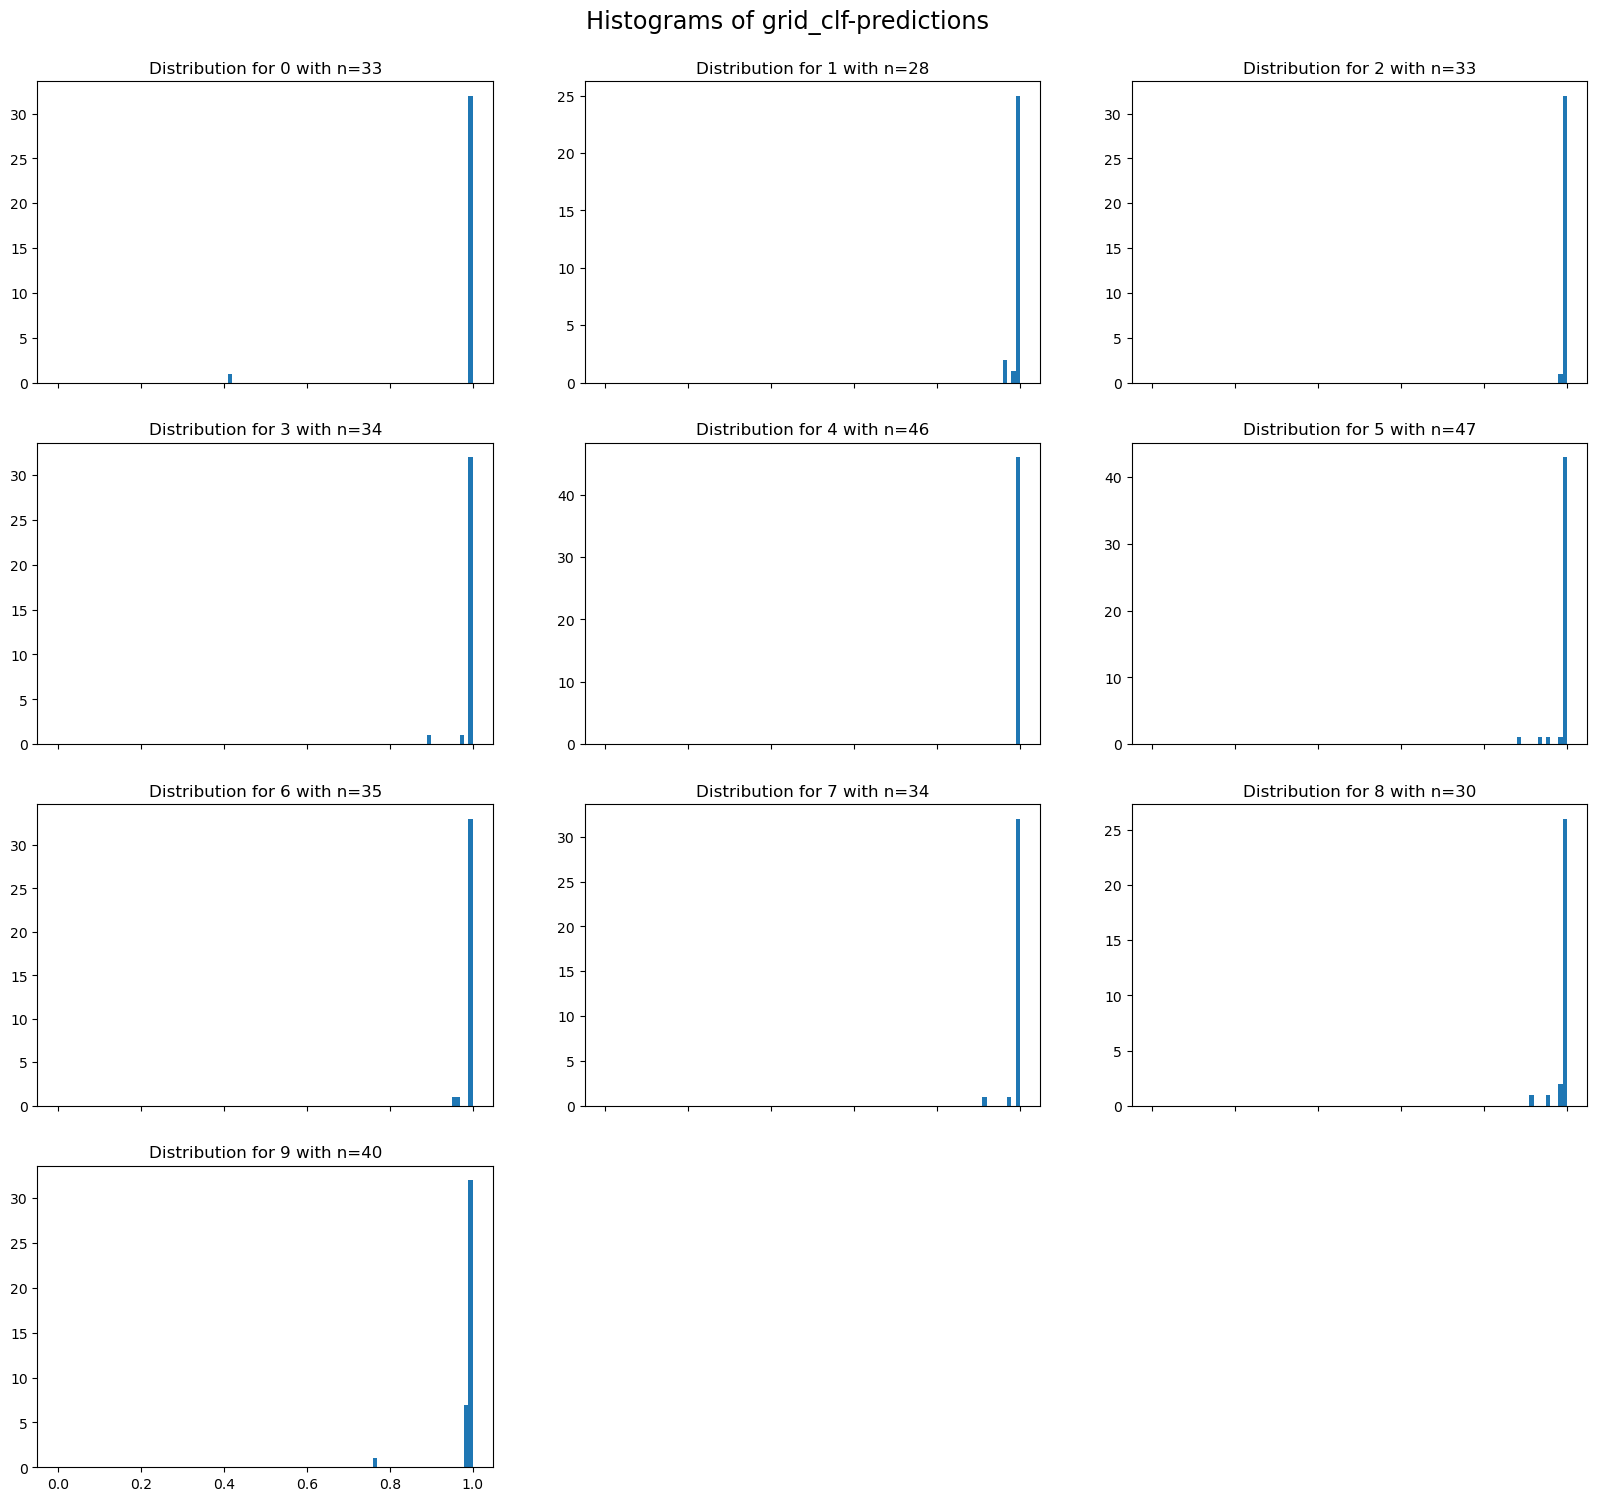

In [63]:
# un-/comment the "switch" variable to decide, for which model the diagrams should be drawn ... could be done in another loop as well...
# the "switch" variable is also used for drawing the ROC-curves later on in this notebook

import matplotlib.pyplot as plt
%matplotlib inline

#switch = "log_reg"
switch = "grid_clf"
nof_classes = 10 # number of classes/labels
nof_diagram_columns = 3
nof_diagram_rows = 4
fig_width = 20 # drawing-area hight
fig_height = 18 # drawing-area width


fig, axs = plt.subplots(nof_diagram_rows,nof_diagram_columns, figsize=(fig_width,fig_height), sharex=True)
fig.suptitle(f"Histograms of {switch}-predictions", size='xx-large', y=0.92)

stats = np.zeros((nof_classes,2)) # contains the values for mean and variance for each class
p_is = []
r = 0
c = 0

for i in range(nof_classes):
    i_mask = y_test == i
    Xi_test = X_test[i_mask] # get the data-point with label i

    if switch == "grid_clf":
        p_i = grid_clf.predict_proba(Xi_test)
    elif switch == "log_reg":
        p_i = log_reg.predict_proba(Xi_test)

    probab_of_pi_is_i = np.array([ b[i] for b in p_i]) # each b contains the predicted probabs of a data-point for all 10 digit-classes. b[i] is the probab to be of class i.
    stats[i, 0] = np.mean(probab_of_pi_is_i) # calculate the mean probab with which a data-point has been classified as belonging to class i.
    stats[i, 1] = np.var(probab_of_pi_is_i) # calculate the variance in probab with which data-points have been classified as belonging to class i.
    p_i_sorted = np.sort(probab_of_pi_is_i) # sort the assigned probabilities in ascending mode
    p_is.append(p_i_sorted) # append the probabs for the digit i to the list

    i_counts, i_bins = np.histogram(p_i_sorted, bins=100, range=(0,1))
    if len(axs.shape) > 1:
        axs[r, c].hist(i_bins[:-1], i_bins, weights=i_counts)
        axs[r, c].set_title(f"Distribution for {i} with n={len(p_is[i])}")

        if c < nof_diagram_columns-1:
            c += 1
        else:
            r += 1
            c = 0
    else:
        axs[r].hist(i_bins[:-1], i_bins, weights=i_counts)
        axs[r].set_title(f"Probability mass allocation for {i} with n={len(p_is[i])}")
        r += 1

axs[3,1].remove()
axs[3,2].remove()


In [52]:
""" 
# explanatory -stepwize code in the foreach-loop: step-by-step un-comment and execute...

p_is = []
r = 0
c = 0

i = 5

i_mask = y_test == i
#i_mask.shape, i_mask.sum()
Xi_test = X_test[i_mask]
#Xi_test.shape
p_i = log_reg.predict_proba(Xi_test)
#p_i.shape, p_i[0]
probab_of_pi_is_i = np.array([ b[i] for b in p_i])
#probab_of_pi_is_i.shape
stats[i, 0] = np.mean(probab_of_pi_is_i) # calculate the mean probab with which a data-point has been classified as belonging to class i.
#stats[i, 0]
stats[i, 1] = np.var(probab_of_pi_is_i) # calculate the variance in probab with which data-points have been classified as belonging to class i.
#stats[i, 1]
p_i_sorted = np.sort(probab_of_pi_is_i)
#p_i_sorted.shape
p_is.append(p_i_sorted)
p_is 

"""


### Draw the curve for the mean probability-mass allocation per class:

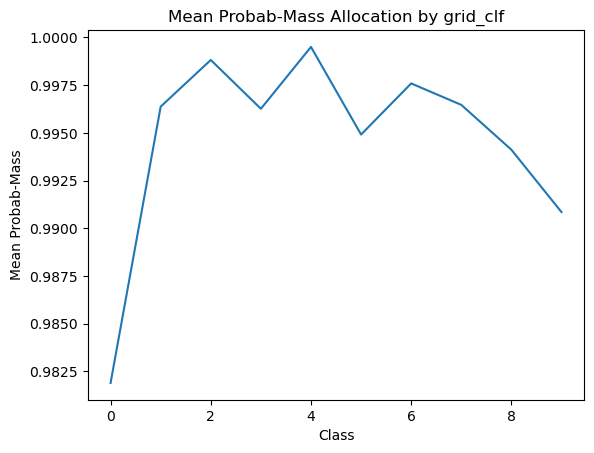

In [64]:
# draw the curve ford the mean probability-mass allocation per class:

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
xs=np.arange(nof_classes)
ys=stats[:,0] # mean probability-mass allocation per class
ax.set_xlabel("Class")
ax.set_ylabel("Mean Probab-Mass")
ax.set_title(f"Mean Probab-Mass Allocation by {switch}")
ax.plot(xs, ys) 

The figure of the "Mean-Probab-Mass Allocation" shows clearly, which classes are problematic because their members are classified with a relatively smal probability-mass allocated. For log_reg the digits "9" have the lowes mean-probab-mass of all, approx. 0.935 so it seems the "9" is more difficult for the classifier than the "1", which on average is allocated 99.8% of the probab-mass, i.e. the classifier is very confident in it's estimate.<br>
The clustered log_reg has two weak spots: "0" and "9" with on average 98,25% and 99.01% of probab-mass that decide about the classification.<br>
... might be seen as preposterous to call a classifier "weak", when it only is 98% sure about it's results ... - obviously the "digits" dataset is to easy a task to really see, if this kind of analysis of a classifier has any value. 

### Calculate sum of means and variances for the probability-mass allocation per class:

In [68]:
# statistics of probabvalues: mean, variance:
s = np.sum(stats, axis=0)

if switch == "grid_clf":
    print(f"Sum of probabilities: {s[0]:.3f} and variances: {s[1]:.3f} assigned by grid-classifier.")
elif switch == "log_reg":
    print(f"Sum of probabilities: {s[0]:.3f} and variances: {s[1]:.3f} assigned by log_reg-classifier.")
# result:
# Sum of probabilities: 9.5623238455677 and variances: 0.3043238373361892  assigned by log_reg-classifier.
# Sum of probabilities: 9.675666433618208 and variances: 0.18160522944854848 assigned by grid-classifier.

Sum of probabilities: 9.947 and variances: 0.013 assigned by grid-classifier.


In [69]:
# statistics of probabvalues: mean, variance:
m = np.mean(stats, axis=0)

if switch == "grid_clf":
    print(f"Mean of probabilities: {m[0]:.3f} and variances: {m[1]:.3f} assigned by grid-classifier.")
elif switch == "log_reg":
    print(f"Mean of probabilities: {m[0]:.3f} and variances: {m[1]:.3f} assigned by log_reg-classifier.")

# result:
# Mean of probabilities: 0.9526218498645296 and variances: 0.030432383733618916 assigned by log_reg-classifier.
# Mean of probabilities: 0.9675666433618207 and variances: 0.01816052294485485 assigned by grid-classifier.

Mean of probabilities: 0.995 and variances: 0.001 assigned by grid-classifier.


Take this conclusion with a grain of salt...:

So we see, that the log_reg classifier has 0.952 of all probability-mass assigned to the right data-points, while the grid_classifier has 0.967. <br>
At the same time, the variance of the log-reg mass-distribution is more spread out, 0.030, than the grid_classifiers with a mean-variance of 0.0182. <br>
<br>
My conclusion would be, that the grid_classifier is a better classifier. <br>
Let's see, what ROC has to say about this.

len(fpr): 10
len(tpr): 10


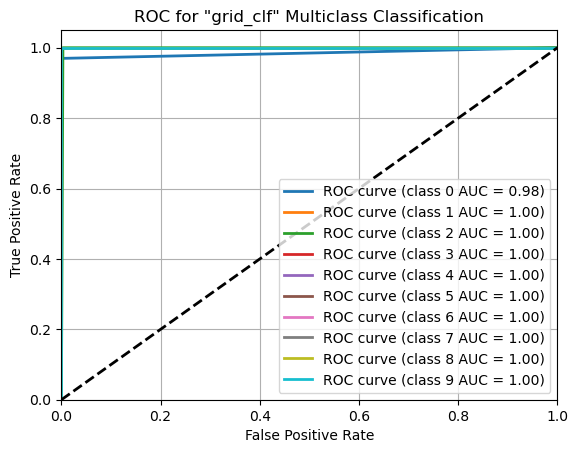

In [101]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

if switch == "grid_clf":
    y_pred = grid_clf.predict_proba(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
elif switch == "log_reg":
    y_pred = log_reg.predict_proba(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_classes) # this is only for binary classification

# OVR - one-versus-rest - Compute ROC curves for each class
n_classes = 10

fpr = dict()
tpr = dict()
roc_auc = dict()

# binarize / one-hot-encode labels - necessary for scikit roc-curves:
classes = np.arange(0,10)
y_test_binarized = label_binarize(y_test_binarized, classes=classes)
y_pred_classes_binarized = label_binarize(y_pred_classes, classes=classes)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_classes_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#debug:
print(f"len(fpr): {len(fpr)}")
print(f"len(tpr): {len(tpr)}")


# Plot the ROC curves
import matplotlib.colors as mcolors
colors_tab = mcolors.TABLEAU_COLORS
colors = list(colors_tab)

plt.figure()
#colors = ['blue', 'black', 'red']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve (class {i} AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC for "{switch}" Multiclass Classification')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Summary:

the comparison of the distribution of the probability-mass for the respective classes shows that it is more spread-out for the log_reg classifier: 
1. the mean of the probabilities is lower, i.e. more smal probabilities are assigned
2. the variance of the probabilities is higher, i.e. the values are more spread out
<br>
That is, the classifier log_reg is worse than the clustered log_reg (i.e. the "grid_classifier"), since we expect a good classifier to be sure about it's assignments (i.e. have mean probability close to one for each instance) and to have very few instances with assignments considerably less than one (low variance). Maybe the last point could be better measured by a comparison of the mean and the median like this: "mean close to median" == "concentrated distribution" (of course we want "mean close to one" in addition).<br>
<br>
Some judgement of the kind above would be nice to get from this analysis, but obviously the digits-dataset is not an example that is apt to show this clearly: both classifiers are very good classifiers for this dataset, so there is not really any difference worth talking about, i.e. worth analysing. <br>
<br>
Another thing that should have been done is at least a statistical t-test to see, if the values we get are at all different - it does not make sense to draw conclusions from experiments that only yield different numbers by chance...

